In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import numpy.random as rn
import networkx as nx
import my_networkx as my_nx

mpl.rcParams.update({'font.size': 25})


In [2]:
A = np.array([[0, 1, 0, 0, 0, 0],[1, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 0],[0, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 1],[0, 0, 0, 0, 1, 0]])
print(A)

[[0 1 0 0 0 0]
 [1 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 1]
 [0 0 0 0 1 0]]


In [109]:
def plot_network(A, ax_plot, we=np.ones_like(A), position={1:(0,0),2:(1,0),3:(2,1),4:(3,0),5:(2,-1),6:(2,0)}, name="figures/Example_Calmodulin_1.pdf", node_color=np.ones(len(A)), edge_name="r", arrstyle="<|-", font_size=20, width_scale=100):
    
    G = nx.DiGraph() 
    edges = []
    k = 0
    color = []
    N = len(A[:,0])
    for i in range(len(A[:,0])): 
        for j in range(len(A[:,0])): 
            if we[i, j] > 0 and A[i, j] == 1: 
                #G.add_edge(i,j)
                if edge_name == "r":
                    edges.append((i+1, j+1, {"weight":we[i,j], "w":r"$r_{%d%d}$" % (j+1, i+1)}))
                elif edge_name == "j":
                    edges.append((i+1, j+1, {"weight":we[i,j], "w":r"$p_{%d}r_{%d%d}$" % (j+1, j+1, i+1)}))
                elif edge_name == "s":
                    edges.append((i+1, j+1, {"weight":we[i,j], "w":""}))
                color.append(we[i,j])

        G.add_node(i+1)

    G.add_edges_from(edges)

    weights = [G[u][v]['weight'] for u,v in G.edges]
    
    width_weight = [w*width_scale for w in weights]

    fixed_positions = position #dict with two of the positions set
    fixed_nodes = fixed_positions.keys()
    pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)

    cmap = plt.cm.plasma

    if edge_name == "r":
        # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10))
        # plt.tight_layout()

        nx.draw_networkx_nodes(G, pos, ax=ax_plot, node_size=3000, edgecolors="k")
        nx.draw_networkx_labels(G, pos, ax=ax_plot, font_size=30)

        curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
        straight_edges = list(set(G.edges()) - set(curved_edges))
        nx.draw_networkx_edges(G, pos, ax=ax_plot, edgelist=straight_edges, arrowstyle="<|-", width=5, node_size=3000)
        arc_rad = 0.10
        edges_plot = nx.draw_networkx_edges(G, pos, ax=ax_plot, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrowstyle=arrstyle, width=weights, edge_color=weights, arrowsize=20, node_size=3000)

        pc = mpl.collections.PatchCollection(edges_plot, cmap=cmap)
        pc.set_array(weights)

        edge_weights = nx.get_edge_attributes(G,'w')
        curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
        straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
        my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax_plot, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=20)
        nx.draw_networkx_edge_labels(G, pos, ax=ax_plot, edge_labels=straight_edge_labels,rotate=False)
        plt.colorbar(pc, ax=ax_plot)
        
    elif edge_name == "j" or edge_name == "s":
        # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), gridspec_kw={'width_ratios': [1, 3]})
        # plt.tight_layout()

        nx.draw_networkx_nodes(G, pos, ax=ax_plot, node_size=3000, edgecolors="k")
        nx.draw_networkx_labels(G, pos, ax=ax_plot, font_size=30)

        curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
        straight_edges = list(set(G.edges()) - set(curved_edges))
        nx.draw_networkx_edges(G, pos, ax=ax_plot, edgelist=straight_edges, arrowstyle=arrstyle, width=width_weight, edge_color=weights, arrowsize=20, node_size=3000)
        arc_rad = 0.15
        edges_plot = nx.draw_networkx_edges(G, pos, ax=ax_plot, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrowstyle="<|-", width=width_weight, edge_color=weights, arrowsize=20, node_size=3000)

        pc = mpl.collections.PatchCollection(edges_plot, cmap=cmap)
        pc.set_array(weights)

        edge_weights = nx.get_edge_attributes(G,'w')
        curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
        straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
        my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax_plot, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=font_size)
        nx.draw_networkx_edge_labels(G, pos, ax=ax_plot, edge_labels=straight_edge_labels,rotate=False, font_size=font_size)
        plt.colorbar(pc, ax=ax_plot)
        
        #ax[0].bar(np.arange(1, N+1), node_color, width=np.ones(N)*0.8, color="green", align="center", edgecolor="black")
        #ax[0].set_xlabel(r"State $i$")
        #ax[0].set_ylabel(r"$p_i$")
        #ax[0].grid()
        #ax[0].set_xticks(np.arange(1, N+1))
        
    # plt.savefig(name, dpi=500, bbox_inches="tight")

In [78]:
def printMatrix(s):
    
    for i in range(len(s)):
        for j in range(len(s[0])):
            print("%.2f   " % (s[i][j]), end="")
        print("\n") 

In [79]:
def Matrices(energies, A):
    N = len(energies)
    peq = np.exp(-energies)
    Z = np.sum(peq)
    peq = peq/Z
    # Probability matrix
    Pmatrix = np.zeros((N, N))
    for i in range(N):
        Pmatrix[i, i] = np.sqrt(peq[i])

    #Master operator DB
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                L[i, j] = np.exp((energies[j]-energies[i])/2)
    for i in range(N):
        L[i, i] = - np.sum(L[:, i])
    # Symmetrised Master op DB
    Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))

    return Pmatrix, L, Ls, peq




## Four state system

In [80]:
def AntiSymmetric(Adj, energies, A):

    N = len(energies)
    Peq, L, Ls, peq = Matrices(energies=energies, A=Adj)
    EWs, EVs = np.linalg.eigh(Ls)
    D = np.diag(EWs)

    A = np.outer(EVs[:, 0], EVs[:, 1]) - np.outer(EVs[:, 1], EVs[:, 0])
    A = A * 0.01
    print("+++++++++++++++++++++++++++++++++++++++")
    printMatrix(A)
    print("+++++++++++++++++++++++++++++++++++++++")
    sqrtLs = np.matmul(EVs, np.matmul(np.diag(np.sqrt(np.abs(EWs))), EVs.T)) 
    Lneq = -np.matmul(sqrtLs, np.matmul(np.identity(N) + A, sqrtLs))

    Lneq_MO = np.matmul(Peq, np.matmul(Lneq, np.linalg.inv(Peq)))

    return Lneq_MO, peq, L  

## Algebraic approach

In [81]:
def k_singlecycle(A: np.ndarray, E: np.ndarray, cyc: np.ndarray, scaling: float):
    """Function to determine the forward and backward cycle pertubation coefficients

    Args:
        A (np.ndarray): Adjacency matrix. 
        E (np.ndarray): Energies.
        cyc (np.ndarray): Cycle array consisting of all vertices in the cycle (start/end point included).

    Returns:
        np.ndarray: Matrix containing the pertubation coefficients
    """
    N = len(E)
    k_matrix = np.zeros((N, N))

    prop = []
    for i in range(len(cyc)-1):
        prop.append(np.exp(-(E[cyc[i]] + E[cyc[i+1]])/2))

    k_value = scaling * min(prop)

    for i in range(len(cyc)-1):
        for j in range(len(cyc)-1):
            k_matrix[cyc[i], cyc[j]] = k_value
            k_matrix[cyc[j], cyc[i]] = - k_value

    return k_matrix

def Independent(c1: np.ndarray, c2: np.ndarray):
    # get intersection between cycles
    intersect = np.intersect1d(c1, c2)
    # size of overlap
    D = len(intersect)
    # size of cycles
    l1 = len(c1)
    l2 = len(c2)
    # if there is only up to single point in intersection, they are independent
    if D < 2:
        return True, [], []
    # need to check if there are multiple points in overlap
    else:
        
        # list of intersection links
        Inter = []
        # list for orientation of parallel segments. If they are parallel, eg both contain 1~2, then add 1, 
        # if, on the other hand, they are anti-parallel, eg cycle 1 contains 1~2 but cycle 2 contains 2~1, 
        # we add a -1
        orientation = []
        for d in range(D):
            # index for d-th overlap element in cycle 1 and 2
            i1 = np.argwhere(c1 == intersect[d])[0, 0]
            i2 = np.argwhere(c2 == intersect[d])[0, 0]
            # print("Index", i1, i2, "value", intersect[d])
            # print("cycle1", "value", c1[i1], "right neighbour", c1[(i1 + 1)%l1], intersect[(d+1)%D])
            # print("cycle2", c2[i2],  "right neighbour", c2[(i2 + 1)%l2],"left neighbour", c2[(i2 - 1)%l2], intersect[(d+1)%D])
            if c1[(i1 + 1)%l1] == c2[(i2 + 1)%l2] and c2[(i2 + 1)%l2] in intersect:
                Inter.append([c1[i1], c1[(i1+1)%l1]])
                orientation.append(1)
            elif c1[(i1 + 1)%l1] == c2[(i2 - 1)%l2] and c2[(i2 - 1)%l2] in intersect:
                Inter.append([c1[i1], c1[(i1+1)%l1]])
                orientation.append(-1)
            
            # elif c1[i1 - 1] == intersect[(d+1)%D] and c2[i2 + 1] == intersect[(d+1)%D]:
            #     Inter.append([intersect[d], intersect[(d+1)%D]])
            # elif c1[i1 - 1] == intersect[(d+1)%D] and c2[i2 - 1] == intersect[(d+1)%D]:
            #     Inter.append([intersect[d], intersect[(d+1)%D]])

        if len(Inter) == 0:
            print(Inter, orientation)
            return True, [], []
        else:
            return False, Inter, orientation

def k_multicycle(A: np.ndarray, E: np.ndarray, cyc: np.ndarray, scaling: np.ndarray, direction: np.ndarray):
    
    # size of network
    N = len(E)
    # final pertubation matrix
    k_matrix = np.zeros((N, N))

    # make 3d matrix with entries of possible k values
    k_prop_matrix = np.zeros((len(cyc), N, N))
    
    # find possible value of k in each cycle
    prop_k_val = []
    for i in range(len(cyc)):
        possible_vals = []
        for j in range(len(cyc[i])):
            possible_vals.append(np.exp(-(E[cyc[i][j]-1] + E[cyc[i][j-1]-1])/2))
        min_val = min(possible_vals)*scaling[i]*direction[i]
        prop_k_val.append(min_val)

        for j in range(len(cyc[i])):
            k_prop_matrix[i, cyc[i][j]-1, cyc[i][j-1]-1] = min_val
            k_prop_matrix[i, cyc[i][j-1]-1, cyc[i][j]-1] = -min_val
    

    # determine dependent cycles
    for i in range(len(cyc)):
        for j in range(i, len(cyc)):
            if i != j:
                # check independence and get intersection and orientation
                check, intersection, orientation = Independent(cyc[i], cyc[j])
                # if they aren't independent, continue
                if not check:
                    for k in range(len(intersection)):
                        pertubation = np.abs(prop_k_val[i] + prop_k_val[j])
                        if pertubation >= np.exp(-(E[intersection[k][0]] + E[intersection[k][1]]) / 2):
                            raise ValueError("Pertubation to large for cycle %d and %d" % (i, j))
                    
    # If all works, we simply add the matrices to get the final pertubation matrix
    for i in range(len(cyc)):
        k_matrix += k_prop_matrix[i]


    return k_matrix


In [82]:
def L_full(A: np.ndarray, E: np.ndarray, cyc: np.ndarray, scaling: np.ndarray, direction: np.ndarray):
    """_summary_

    Args:
        A (np.ndarray): Adjecency matrix, NxN. Needed to leave structure the same.
        E (np.ndarray): Energies of states, N. For invariant probability measure and transition rates.

    Returns:
        np.ndarray: Full master operator
        np.ndarray: Steady state probability vector
        np.ndarray: Antisymmetric part
        np.ndarray: Symmetric part
    """

    # size of system
    N = len(E)

    # Pertubation coefficient matrix
    k = np.zeros((N,N))

    if len(cyc) == 1:
        k = k_singlecycle(A, E, cyc, scaling)
    elif len(cyc) > 1:
        k = k_multicycle(A, E, cyc, scaling, direction)

    L = np.zeros_like(A)

    # probability vector
    peq = np.exp(-E) / np.sum(np.exp(-E))

    # symmetric part of master operator
    Ls = np.zeros((N, N))
    # off-diagonal entries
    for i in range(N):
        for j in range(N):
            # check for edge
            if A[i, j] == 1:
                Ls[i, j] = np.exp((E[j] - E[i])/2)
                # Ls[j, i] = np.exp((E[i] - E[j])/2)
        
    # diagonal entries
    for i in range(N):
        Ls[i, i] = -np.sum(Ls[:, i])
    
    # antisymmetric part
    La = np.zeros((N, N))
    # only has off-diagonal entries
    for i in range(N):
        for j in range(N):
            # check for edge
            if A[i, j] == 1:
                La[i, j] = k[i, j]* np.exp(E[j])

    # full master operator is sum of symmetric and antisymmetric part    
    L = La + Ls

    return L, peq, La, Ls

## Five state multi-cycle example

In [92]:
N = 5

Adj = np.array([[0, 1, 0, 1, 0], [1, 0, 1, 1, 0], [0, 1, 0, 1, 1], [1, 1, 1, 0, 1], [0, 0, 1, 1, 0]])
Energies = rn.uniform(low=0.0, high=1.0, size=(N))

c1 = np.array([1, 2, 4])
c2 = np.array([1, 2, 3, 5, 4])
c3 = np.array([2, 3, 4])


cyc = np.array([c1, c2, c3])

scaling = np.array([0.3, 0.4, 0.5])
direction = np.array([-1, 1, -1])

L, peq, La, Ls = L_full(Adj, Energies, cyc, scaling, direction)

# plot_network(Adj, we=0.1*Adj, position=pos, name="figures/3cycles", node_color=np.ones(5), edge_name="r")
# printMatrix(Adj)

In [93]:

current = np.zeros_like(L)
current_s = np.zeros_like(Ls)


for i in range(5):
    for j in range(5):
        if Adj[i, j] == 1:
            current_s[i, j] = peq[i] * Ls[j, i]
            current[i, j] = peq[i] * L[j, i]


J = np.zeros_like(L)
Js = np.zeros_like(L)

Js = current_s - current_s.T
J = current - current.T

J[np.where(J < 0)] = 0

printMatrix(J)


0.00   0.01   0.00   0.00   0.00   

0.00   0.00   0.00   0.06   0.00   

0.00   0.05   0.00   0.00   0.13   

0.01   0.00   0.18   0.00   0.00   

0.00   0.00   0.00   0.13   0.00   



[1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

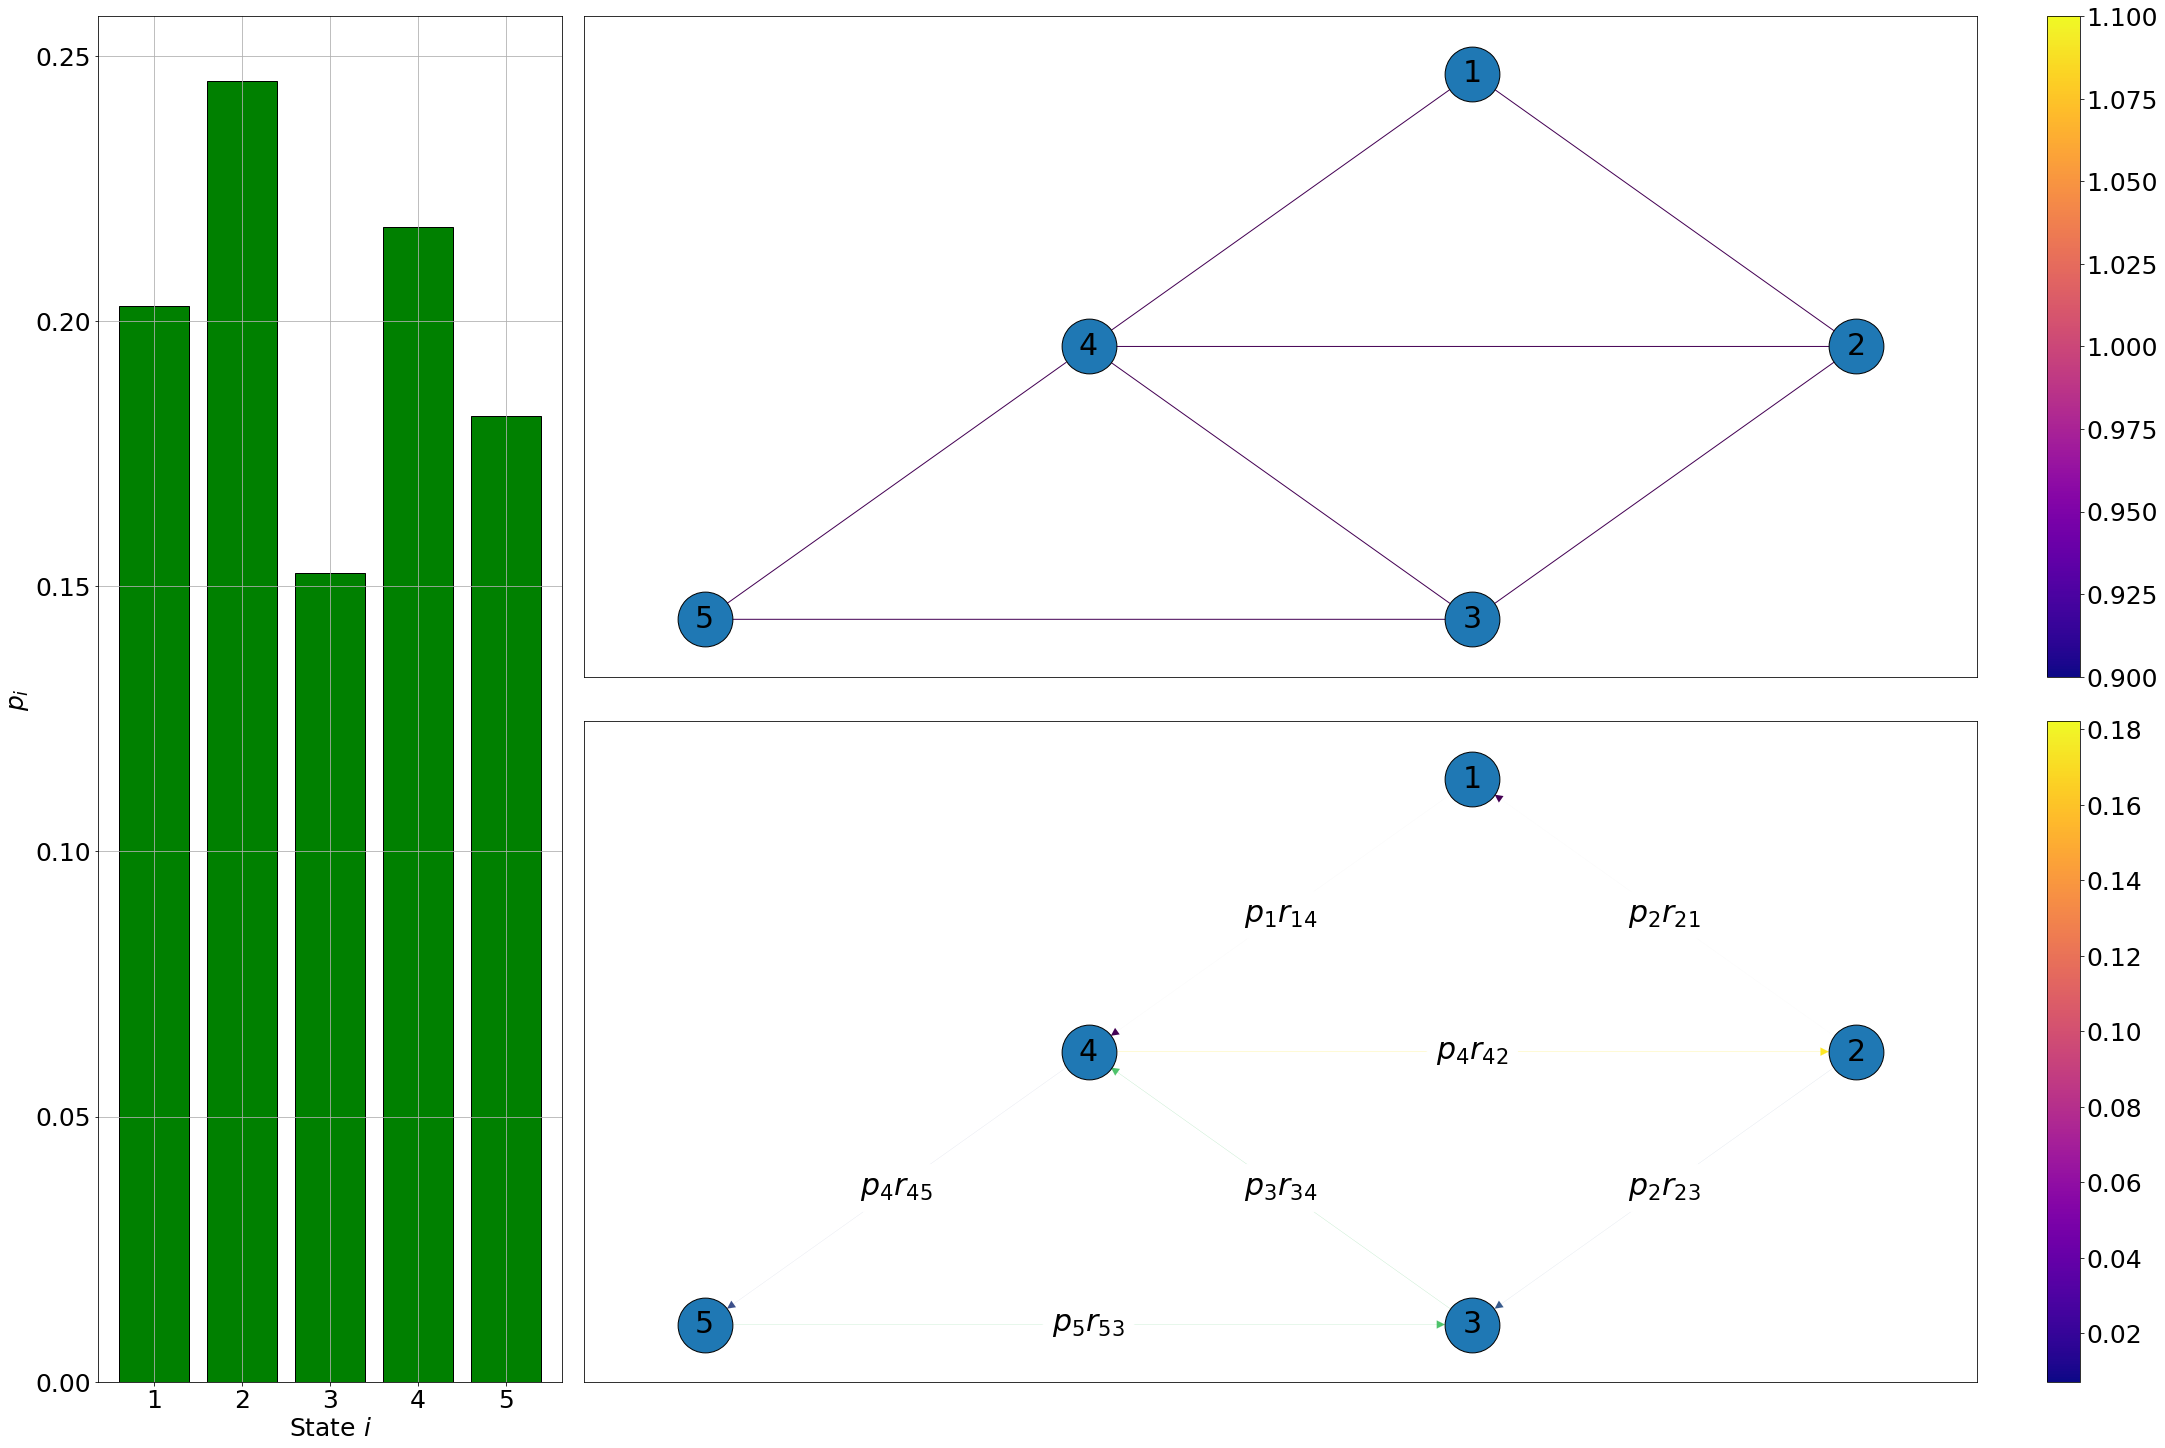

In [108]:
pos = {1:(1, 1), 2:(2, 0), 3:(1, -1), 4:(0, 0), 5:(-1, -1)}


fig = plt.figure(constrained_layout=True, figsize=(30, 20))
axs = fig.subplot_mosaic([["Left", "TopRight"], ["Left", "BottomRight"]], gridspec_kw={"width_ratios":[1, 3]})



axs["Left"].bar(np.arange(1, N+1), peq, width=np.ones(N)*0.8, color="green", align="center", edgecolor="black")
axs["Left"].set_xlabel(r"State $i$")
axs["Left"].set_ylabel(r"$p_i$")
axs["Left"].grid()
axs["Left"].set_xticks(np.arange(1, N+1))

plot_network(Adj, axs["TopRight"], np.triu(Adj), pos, edge_name="s", arrstyle="-")
plot_network(Adj, axs["BottomRight"], J, pos, edge_name="j", font_size=30)




## Four state example

In [10]:
# Four state example
Adj = np.array([[0, 1, 1, 0], [1, 0, 1, 0], [1, 1, 0, 1], [0, 0, 1, 0]])
Energies = rn.uniform(low=0.0, high=3.0, size=(4))

In [11]:
E = np.array([np.exp(-(Energies[0] + Energies[1]) / 2), np.exp(-(Energies[0] + Energies[2]) / 2), np.exp(-(Energies[2] + Energies[1]) / 2)])

e = min(E)

Weight = np.array([[0, e/2, -e/2, 0], [-e/2, 0, e/2, 0], [e/2, -e/2, 0, 0], [0, 0, 0, 0]])

L, p, La, Ls = L_full(Adj, Energies, Weight, [], 0.5)

In [12]:
current_s = np.zeros((4, 4))
current = np.zeros((4, 4))


for i in range(4):
    for j in range(4):
        if Adj[i, j] == 1:
            current_s[i, j] = p[i] * Ls[j, i]
            current[i, j] = p[i] * L[j, i]

pos = {1:(0, 0), 2:(0.5, 1.5), 3:(1, 0), 4:(1, 1.5)}



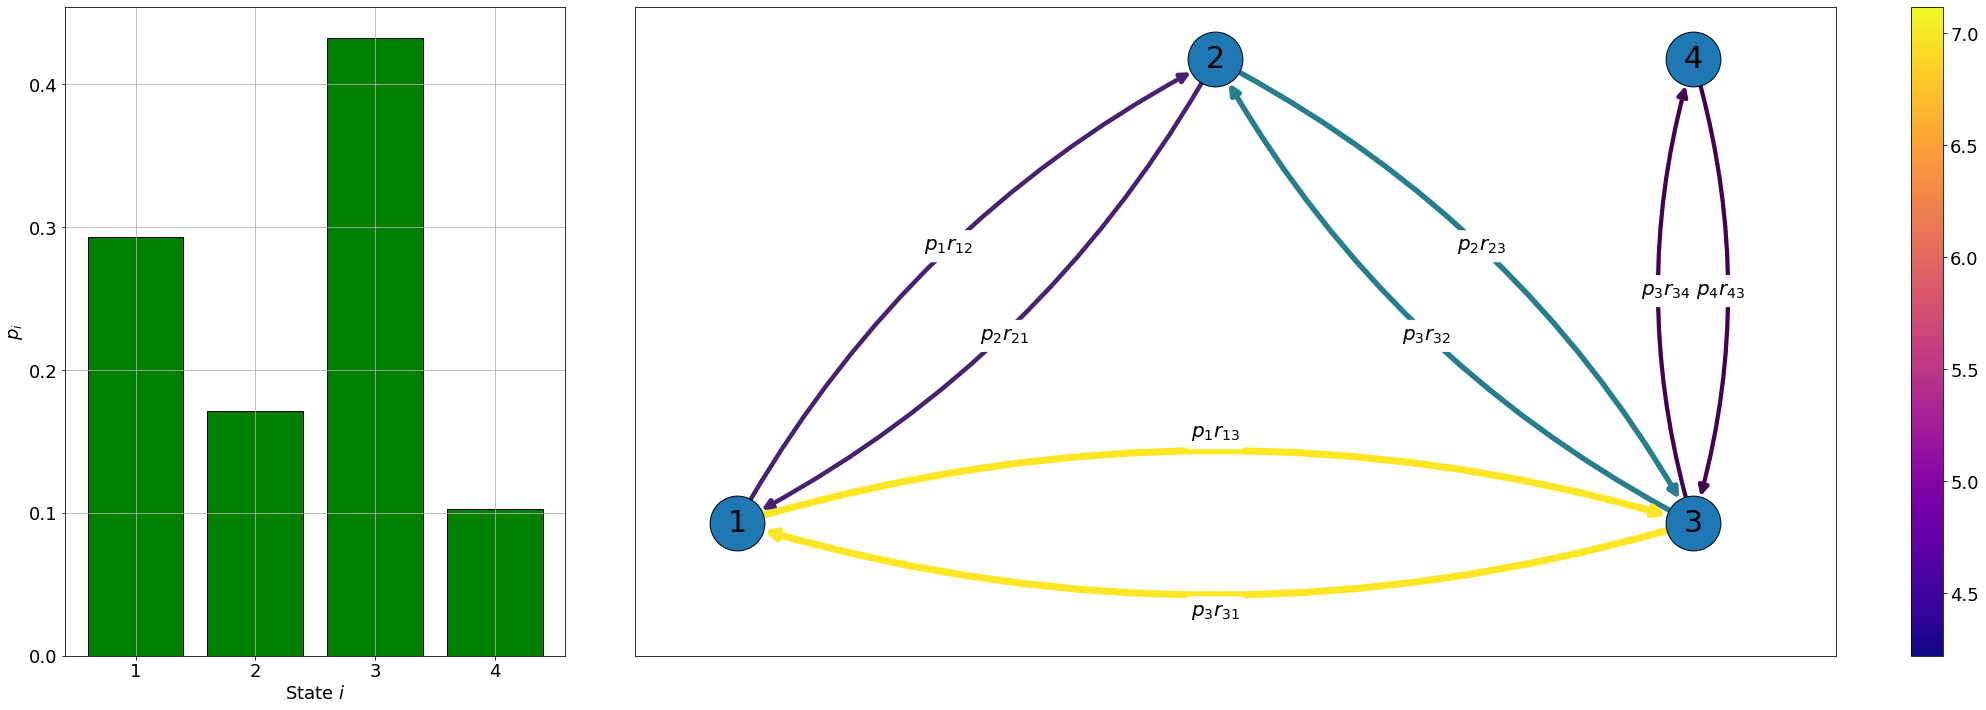

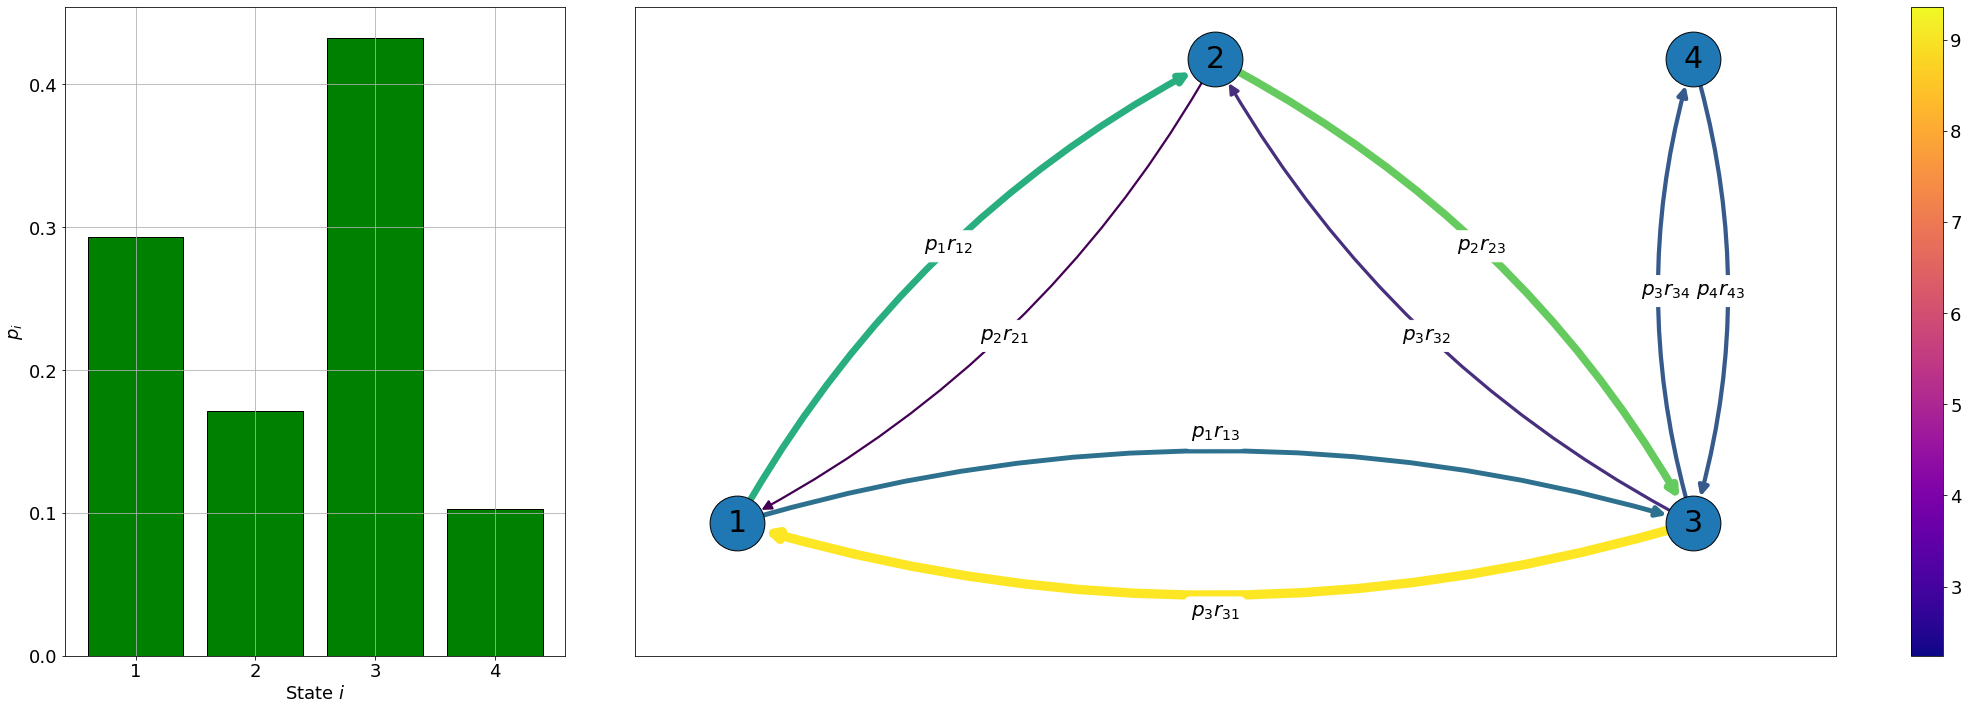

In [13]:
plot_network(Adj, we=current_s, position=pos, name="figures/4state_eq", node_color=p, edge_name="j")
plot_network(Adj, we=current, position=pos, name="figures/4state_neq", node_color=p, edge_name="j")

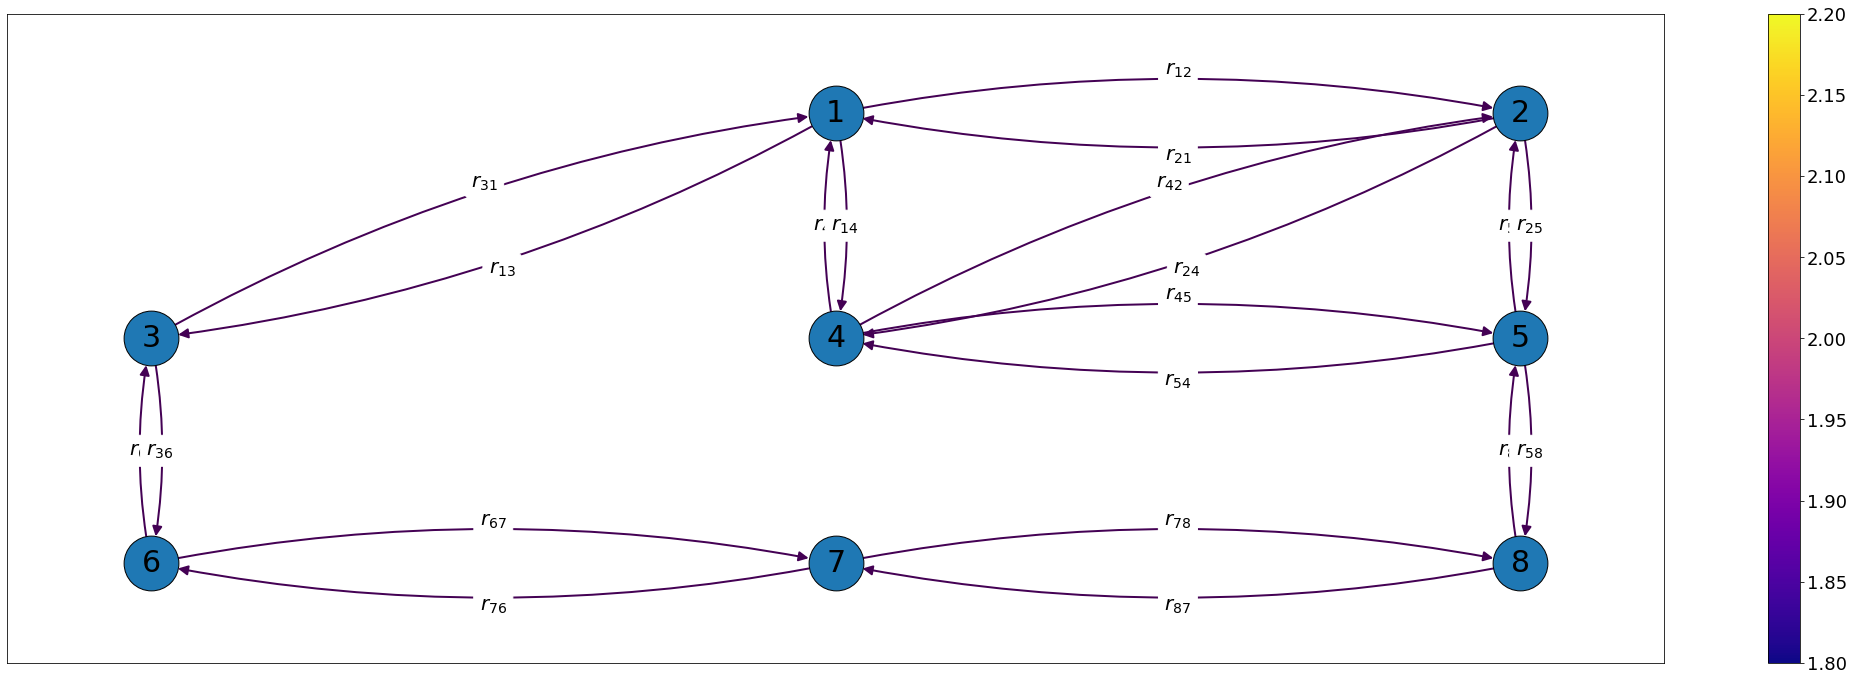

In [14]:
A = np.zeros((8, 8))

A[0, 1] = 1
A[1, 0] = 1
A[1, 3] = 1
A[3, 1] = 1
A[3, 4] = 1
A[4, 3] = 1
A[4, 7] = 1
A[7, 4] = 1
A[7, 6] = 1
A[6, 7] = 1
A[5, 6] = 1
A[6, 5] = 1
A[5, 2] = 1
A[2, 5] = 1
A[0, 2] = 1
A[2, 0] = 1
A[0, 3] = 1
A[3, 0] = 1
A[1, 4] = 1
A[4, 1] = 1


position = {1:(1, 2), 2:(2, 2), 3:(0, 1), 4:(1, 1), 5:(2, 1), 6:(0, 0), 7:(1, 0), 8:(2, 0)}

plot_network(A, A*0.1, position, name="figures/Example_mutliple_edges.pdf", node_color=np.ones(len(A)))







